In [2]:
from pokergame import Table, Player, Deck

In [3]:
t = Table('someid', 0.5, 1)

### Skewed preflop
- Players enter the room
- Players Set their strategies
  - For each node in preflop game tree:
      - fix range and send to server
- Game starts (in particular non-finite node libe 3bet)
  - server evaluates chance nodes and fixates winrate per hand 
  - each round: 
    - random hand is sampled 
    - players play their hand
- Game ends
  - server scales per-hand winrates for amount of hands


### MVP
- Players enter game
- Players fix ranges and potsize for preflop sampling (no evals or anything just two ranges)
- Game starts
- Each round:
  - oop holdings sampled
  - ip holdings sampled form skewed range
  - game starts from flop with chosen pot size and players holdings
  - players play their actions
  - runout is sampled from skewed ranges
  - round ovah

In [106]:
suits = list('shdc')
ranks = list('AKQJT98765432')

class Card:
    def __init__(self, idx):
        assert idx >= 0 and idx < 52
        # 2s3s4s..As2h3h...Ac
        self.suit = idx // 13
        self.rank = idx % 13
        self.idx = idx
    def __repr__(self):
        return f'{ranks[self.rank]}{suits[self.suit]}'


class Holding:
    def __init__(self, c1: Card, c2: Card):
        assert c1.idx != c2.idx
        # sort by rank
        # c1 <= c2
        c1, c2 = sorted([c1, c2], key=lambda x: x.rank)
        self.c1 = c1
        self.c2 = c2

        # poket pair
        if c1.rank == c2.rank:
            self.idx = (c1.rank, c1.rank)
        # suited
        elif c1.suit == c2.suit:
            # y < x
            self.idx = (c1.rank, c2.rank)
        # offsuit
        else:
            self.idx = (c2.rank, c1.rank)
    def __repr__(self):
        return f'{self.c2} {self.c1}'

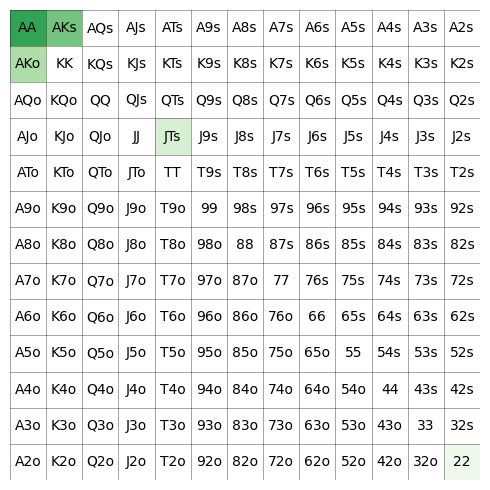

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

class Range:
    def __init__(self, matrix=np.zeros((13, 13))):
        assert matrix.shape==(13, 13)
        # Initialize 13x13 matrix (AA at [0,0], 22 at [12,12])
        self._range = matrix
    
    def set_holding(self, h: Holding, p: float) -> None:
        assert p >= 0 and p <= 1
        i, j = h.idx
        self._range[i, j] = p
    
    def get_holding(self, h: Holding) -> float:
        i, j = h.idx
        return self._range[i, j]

    def display(self) -> None:
        fig, ax = plt.subplots(figsize=(5, 5))
        
        # Remove all ticks and borders
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Custom color gradient (white to dark green)
        colors = ["#ffffff", "#e5f5e0", "#a1d99b", "#31a354"]
        cmap = LinearSegmentedColormap.from_list("poker", colors)
        
        plt.imshow(self._range, cmap=cmap, vmin=0, vmax=1)
        
        for i in range(14):
            ax.axhline(i-0.5, color='black', linewidth=0.5, alpha=0.5)
            ax.axvline(i-0.5, color='black', linewidth=0.5, alpha=0.5)
        
        # Add hand labels inside each cell
        for i in range(13):
            for j in range(13):
                # Pocket pairs (AA, KK, ..., 22)
                label = ''
                if i == j:
                    label = f"{ranks[i]}{ranks[j]}"
                
                # Suited hands (AKs, KQs, etc. - upper triangle)
                elif i < j:
                    label = f"{ranks[i]}{ranks[j]}s"

                # Offsuit hands (AKo, KQo, etc. - lower triangle)
                else:
                    label = f"{ranks[j]}{ranks[i]}o"
                
                ax.text(j, i, label, ha='center', va='center', fontsize=10)

                
        
        # Make cells square
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()
       

r = Range()
# Set some sample hands
r._range[0, 0] = 1.0     # AA
r._range[0, 1] = 0.8     # AKs
r._range[1, 0] = 0.6     # AKo
r._range[12, 12] = 0.2   # 22
r._range[3, 4] = 0.4     # JTs

r.display()

In [ ]:



class Deck:
    def __init__(self):
        # Initialize card availability (1 = available, 0 = blocked)
        self.card_live = np.ones(52, dtype=bool)  

    def sample_hand(self, r: Range) -> Holding: # As, Ah
        # sample combination
        # assign suit
        p = np.zeros([52, 52])
        for i in range(52):
            if not self.card_live[i]:
                continue
            for j in range(52):
                if not self.card_live[j] or i == j:
                    continue
                # both cards live
                c1, c2 = Card(i), Card(j)
                h = Holding(c1, c2)
                idx = h.idx
                p[j, i] = r._range[idx[0], idx[1]]
        res = np.random.choice(52*52, p = p.flatten() / p.flatten().sum())
        idx1, idx2 = res // 52, res % 52
        self.card_live[idx1] = False
        self.card_live[idx2] = False
        return Holding(Card(idx1), Card(idx2))

deck = Deck()
range_matrix = np.zeros((13,13))
range_matrix[0,0] = 1.0  # AA
range_matrix[0,1] = 0.8  # AKs
range_matrix[1,0] = 0.6  # AKo

h1 = deck.sample_hand(Range(range_matrix))
print(f"Player 1: {h1}")  # e.g., "AA"

h2 = deck.sample_hand(Range(range_matrix)) 
print(f"Player 2: {h2}")  # e.g., "AKo" (can't be AKs if AsKs was blocked)

Player 1: Ah Ad
Player 2: As Ac
